# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [4]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Loading and preparing data

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
## Cross-immune 
adata = sc.read("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")

In [3]:
adata.layers["counts"] = adata.raw.X.copy() 
# copy counts
adata.X = adata.raw.X.copy()

adata.X.shape, adata.raw.X.shape, adata.layers["counts"].shape

((329762, 36503), (329762, 36503), (329762, 36503))

In [5]:
## High level cell types

from sanity_checks_utils import (
    GROUPS,
    read_almudena_signature,
    map_hgnc_to_ensg,
    perform_nnls,
    compute_correlations,
)
# primary cell type categories
groups = GROUPS["primary_groups"]

# create cell types
group_correspondence = {}
for k, v in groups.items():
    for cell_type in v:
        group_correspondence[cell_type] = k
adata.obs["cell_types_grouped"] = [
    group_correspondence[cell_type] for cell_type in adata.obs.Manually_curated_celltype
]

adata.obs["cell_types_grouped"].value_counts()

cell_types_grouped
TNK          216611
B             52788
MonoMacro     45844
To remove      8750
Mast           3291
DC             2478
Name: count, dtype: int64

Handcrafted signature matrix

In [ ]:
from sanity_checks_utils import (
    GROUPS,
    read_almudena_signature,
    map_hgnc_to_ensg,
    perform_nnls,
    compute_correlations,
)
# prim

signature = read_almudena_signature(
    "/home/owkin/project/Almudena/Output/Crosstiss_Immune_norm/CTI.txt"
) 

# intersection between all genes and marker genes
intersection = list(set(adata.var_names).intersection(signature.index))
signature = signature.loc[intersection]

signature.head()

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [8]:
 # preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

#### Batch ids

In [9]:
adata.obs["donor_id"].value_counts(), adata.obs["assay"].value_counts()

(donor_id
 D496    88057
 D503    79004
 640C    35527
 637C    25843
 A36     24105
 A29     17327
 A31     12446
 582C    11590
 A35     11105
 621B    10632
 A37      9806
 A52      4320
 Name: count, dtype: int64,
 assay
 10x 3' v3    167061
 10x 5' v2     83592
 10x 5' v1     79109
 Name: count, dtype: int64)

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="assay",
)

In [11]:
excluded_genes = set(signature.index) - set(adata.var_names)

len(excluded_genes)

54

In [12]:
# import numpy as np

# for gene in excluded_genes:
#     #x = adata[:, gene].layers["counts"].toarray()
#     x_norm = adata.raw[:, gene].X.toarray()
#     print(f"Gene {gene} : {np.mean(x_norm), np.var(x_norm)}")

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [14]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["assay", "donor_id"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [15]:
scvi.model.CondSCVI.setup_anndata(adata,
                                  layer="counts",
                                  labels_key="cell_type",
)

```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [16]:
model = scvi.model.SCVI(adata)

# model.view_anndata_setup()

In [17]:
model.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [43:32<00:00, 25.80s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=992]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [43:32<00:00, 26.13s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=992]


```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

In [ ]:
# model_cond = scvi.model.CondSCVI(adata, weight_obs=True)

# model_cond.view_anndata_setup()

In [ ]:
# model_cond.train(max_epochs=100)

In [21]:
# plt.plot(model_cond.history["elbo_train"])
# plt.plot(model_cond.history["reconstruction_loss_train"])

### Load saved Model and Anndata object 

In [5]:
adata = ad.read_h5ad("/home/owkin/deepdeconv/notebooks/models/adata_cti_5000.h5ad")

adata

AnnData object with n_obs × n_vars = 329762 × 5000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_types_grouped', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_ontology_term_id_colors', 'default_embedding', 'hvg', 'log1p', 'schema_vers

In [ ]:
model = scvi.model.SCVI.load(dir_path="/home/owkin/deepdeconv/notebooks/models/",
                             adata=adata,
                             use_gpu=True
                             )

model.view_anndata_setup()

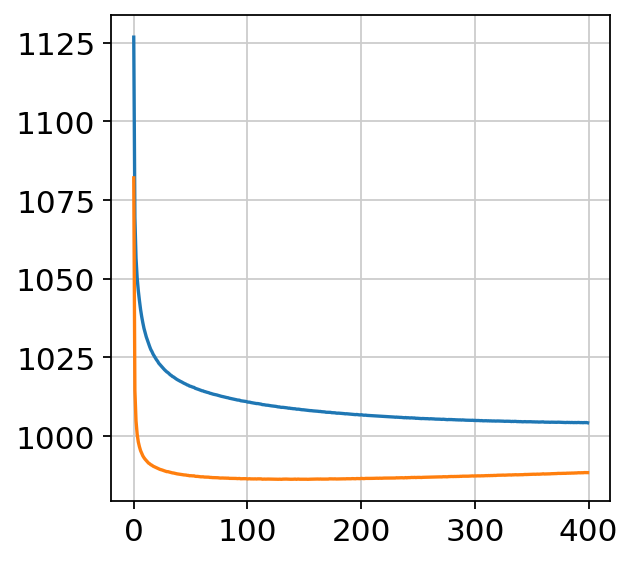

In [7]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])

### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [11]:
# model.save("my_model/")

In [12]:
# model = scvi.model.SCVI.load("my_model/", adata=adata, use_gpu=True)

## Latent space

In [8]:
# Regular scVI
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

latent.shape

(329762, 10)

In [22]:
# CondscVI
# latent_cond = model_cond.get_latent_representation()
# adata.obsm["X_condSCVI"] = latent_cond

# latent_cond.shape

## 2D Embedding plots

#### scVI latent space 

In [9]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


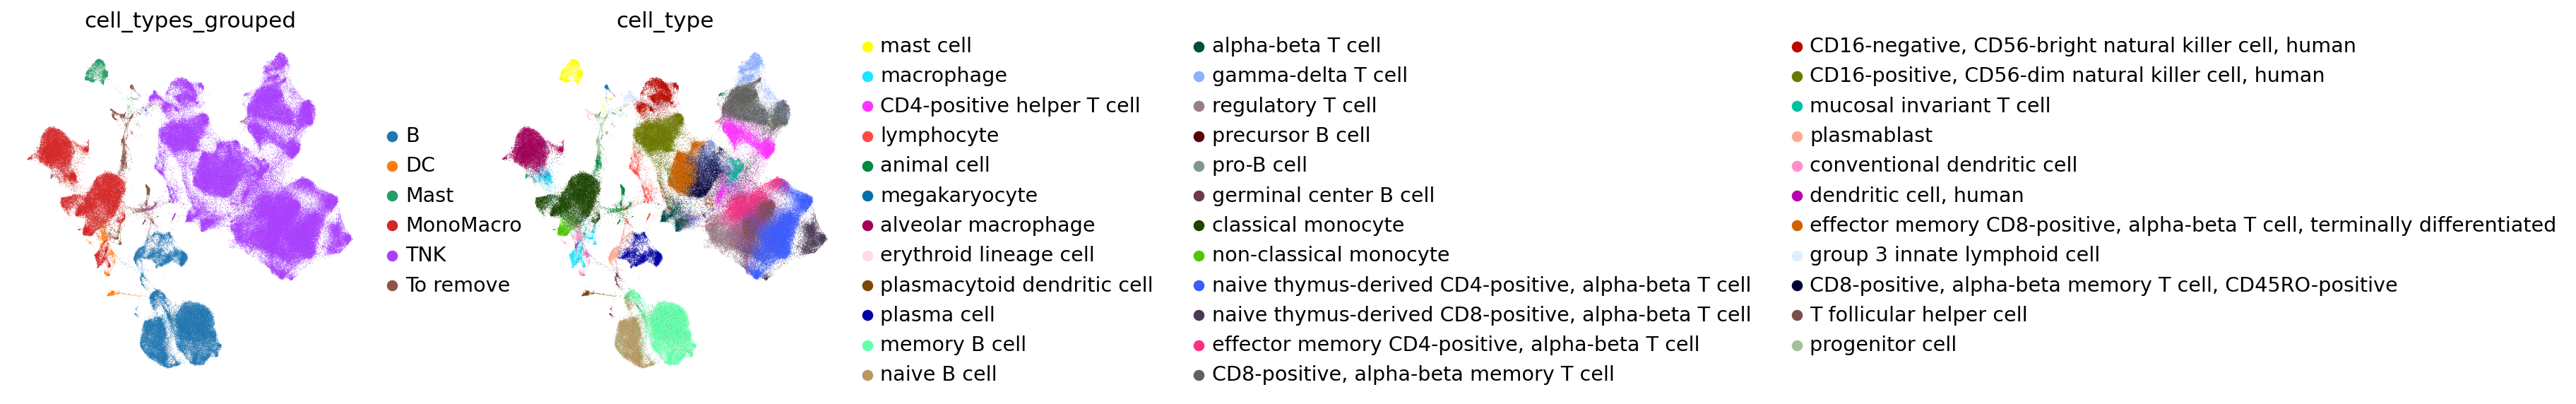

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


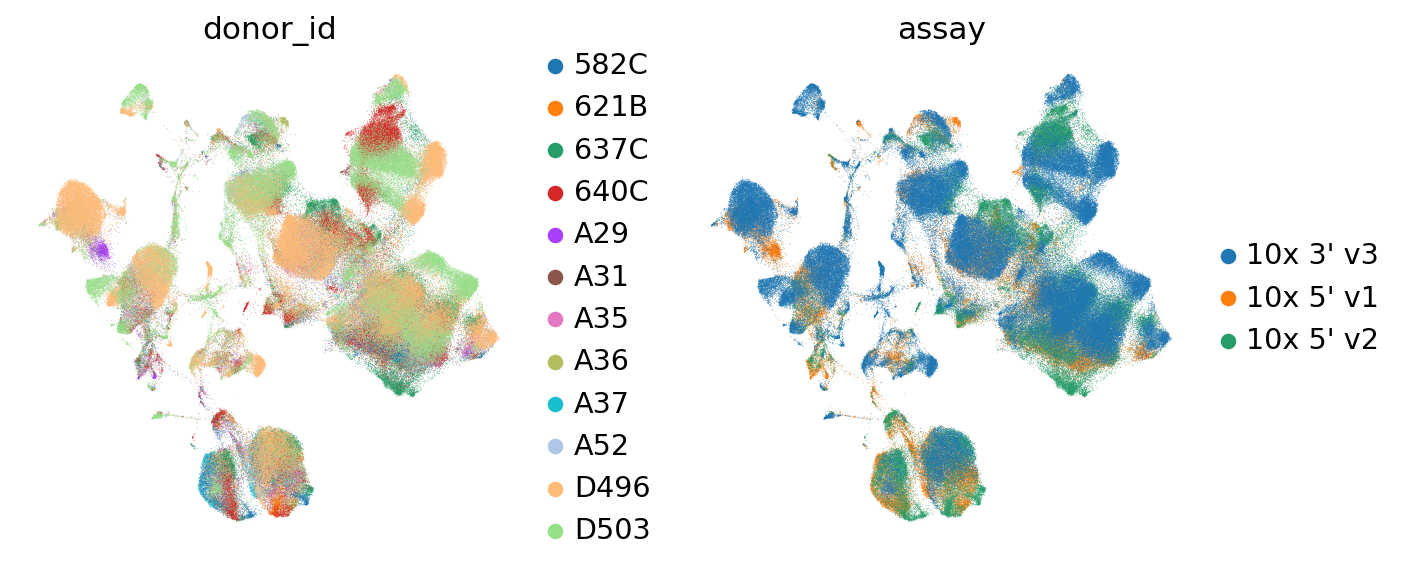

In [10]:
sc.pl.umap(
    adata,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

#### condSCVI latent space 

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


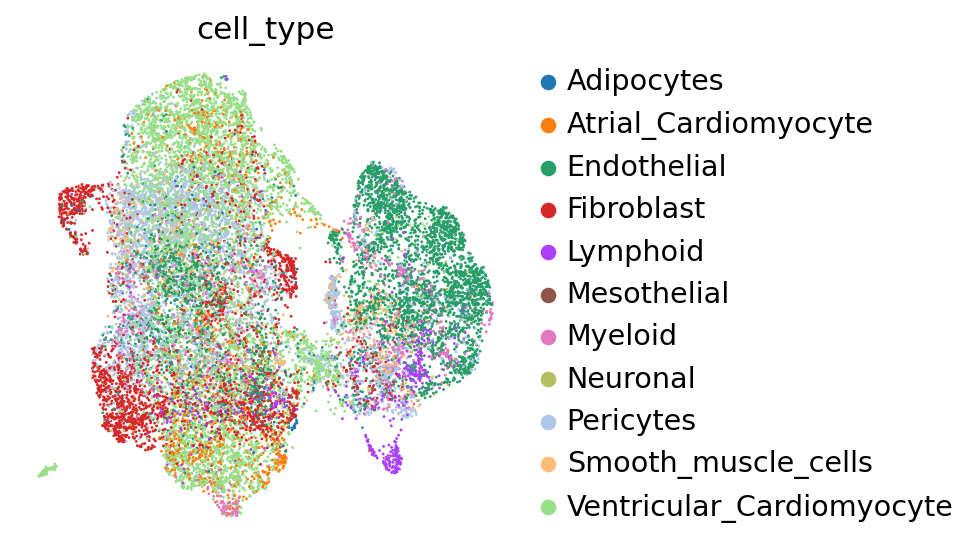

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


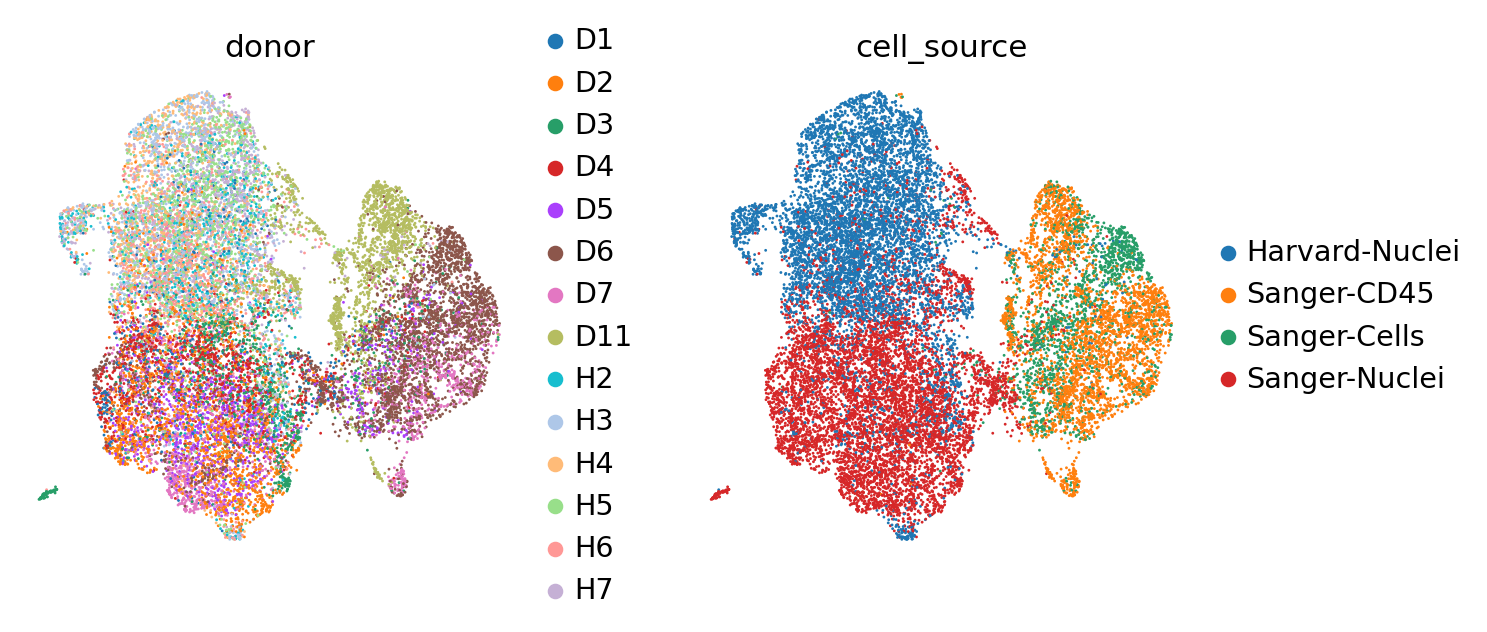

In [112]:
# # run PCA then generate UMAP plots
# sc.pp.neighbors(adata, use_rep="X_condSCVI")
# sc.tl.umap(adata, min_dist=0.3)

# sc.pl.umap(
#     adata,
#     color=["cell_type"],
#     frameon=False,
# )
# sc.pl.umap(
#     adata,
#     color=["donor_id", "assay"],
#     ncols=2,
#     frameon=False,
# )

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

## Create Signature matrix

scVI

In [10]:
# Denoised signature computation

df_signature_denoised = pd.DataFrame()

for cell_type in adata.obs["cell_types_grouped"].unique():
    indices = adata[adata.obs.cell_types_grouped == cell_type].obs.index
    integer_indices = adata.obs.index.get_indexer(indices)
    # latent_subset = model.get_latent_representation(adata_subset)
    denoised = model.get_normalized_expression(indices=integer_indices,
                                               library_size=1e4)
    df = denoised.mean(axis=0).to_frame()
    df.columns = [cell_type]
    df_signature_denoised = pd.concat([df_signature_denoised, df], axis=1)

In [1]:
denoised_full = model.get_normalized_expression(
                                            library_size=1e4)

NameError: name 'model' is not defined

In [14]:
signature.index.name = "gene_ids"

signature.head()

,TNK,B,MonoMacro,DC,Mast
gene_ids,,,,,
ENSG00000100079,0.002603,0.002155,0.167784,0.790436,0.000601
ENSG00000104921,0.002168,0.703532,0.008103,0.029109,0.000658
ENSG00000119655,0.24024,0.5222,1.745101,1.391158,0.769935
ENSG00000083454,0.098741,0.993843,0.006311,0.058529,0.010287
ENSG00000163683,0.078531,0.733793,0.330975,0.449305,0.135932


In [15]:
df_signature_denoised.drop(["To remove"], axis=1, inplace=True)

df_signature_denoised.head()

,TNK,MonoMacro,B,DC,Mast
gene_ids,,,,,
ENSG00000187634,0.014731,0.009122,0.025526,0.025245,0.053311
ENSG00000188290,4.306681,1.571459,2.857157,2.182071,15.379998
ENSG00000187608,6.314407,3.629999,2.434287,3.733716,3.975263
ENSG00000186891,2.540326,0.287756,0.648323,1.507429,1.483977
ENSG00000186827,2.443013,0.478868,0.533585,1.128282,2.350876


In [16]:
keep_genes = list(set(signature.index) & set(df_signature_denoised.index))

signature = signature.loc[keep_genes]
df_signature_denoised = df_signature_denoised.loc[keep_genes]

In [17]:
signature, df_signature_denoised

(                      TNK         B MonoMacro        DC      Mast
 gene_ids                                                         
 ENSG00000100079  0.002603  0.002155  0.167784  0.790436  0.000601
 ENSG00000104921  0.002168  0.703532  0.008103  0.029109  0.000658
 ENSG00000119655   0.24024    0.5222  1.745101  1.391158  0.769935
 ENSG00000083454  0.098741  0.993843  0.006311  0.058529  0.010287
 ENSG00000163683  0.078531  0.733793  0.330975  0.449305  0.135932
 ...                   ...       ...       ...       ...       ...
 ENSG00000196735  0.089737  1.854391  1.053925  2.532143  0.016533
 ENSG00000182718  0.335819  0.262258  1.876325  1.005993  0.117609
 ENSG00000132002  2.075775   1.38194  0.563821  0.954131  1.585084
 ENSG00000169429  0.025698  0.010749  1.197765  0.374699  0.127703
 ENSG00000104763  0.234539  0.412688   1.69511   0.52233  1.231939
 
 [221 rows x 5 columns],
                         TNK  MonoMacro          B         DC       Mast
 gene_ids                    

In [ ]:
df_signature_denoised.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/signature_cti_csv_5000.csv")

condSCVI

In [18]:
# Denoised signature computation

# df_signature_cond_denoised = pd.DataFrame()

# for cell_type in adata.obs["cell_type"].unique():
#     indices = adata[adata.obs.cell_type == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     # latent_subset = model.get_latent_representation(adata_subset)
#     denoised = model_cond.get_normalized_expression(adata,
#                                                     indices=integer_indices,
#                                                     library_size=1e4)
                                                
                                               
#     df = denoised.mean(axis=0).to_frame()
#     df.columns = [cell_type]
#     df_signature_cond_denoised = pd.concat([df_signature_cond_denoised, df], axis=1)

Vanilla signature matrix

In [19]:
# X_norm = sc.pp.normalize_total(adata,
#                                target_sum=1e4,
#                                layer="counts",
#                                inplace=False)['X']

# df_signature = pd.DataFrame()

# for cell_type in adata.obs["cell_type"].unique():
#     indices = adata[adata.obs.cell_type == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     df = pd.DataFrame(X_norm[integer_indices, :].mean(axis=0).T,
#              index=adata.var_names,
#              columns=[cell_type])
#     df_signature = pd.concat([df_signature, df], axis=1) 

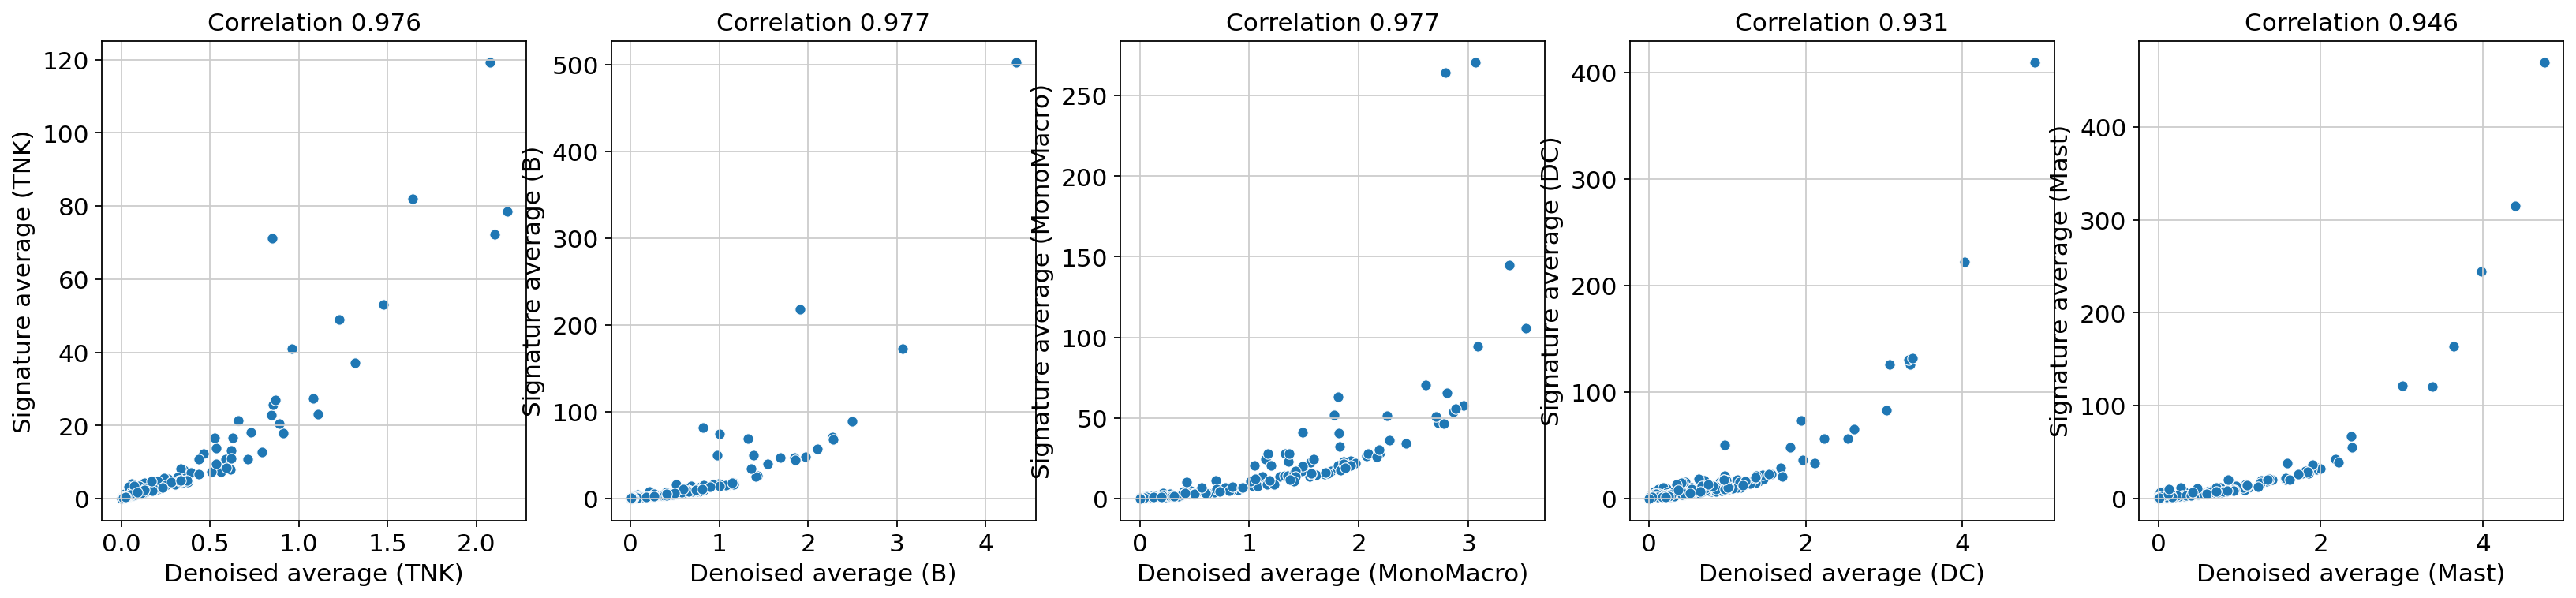

In [22]:
import seaborn as sns 
from scipy.stats import spearmanr, pearsonr
import numpy as np
cell_types = list(signature.columns)

n_cols = 5

fig, ax = plt.subplots(1, n_cols, figsize=(25, 5))

for i in range(n_cols):
    cell_type = cell_types[i]
    x_sig = signature[cell_type].values
    x_denoised = df_signature_denoised[cell_type].values
    # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
    # x_raw = df_signature.loc[keep_genes][cell_type].values
    # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
    corr = spearmanr(x_sig, x_denoised)[0]
    
    sns.scatterplot(x=x_sig,
                    y=x_denoised,
                    ax=ax[i]
                    )
    ax[i].set_xlabel(f"Denoised average ({cell_type})")
    ax[i].set_ylabel(f"Signature average ({cell_type})")
    ax[i].set_title(f"Correlation {np.around(corr,3)}")

In [ ]:
# marker_genes = {"Endothelial": ["EGFL7", "VWF", "SLC9A3R2"],
#                 "Neuronal": ["NRXN1", "GPM6B", "L1CAM"],
#                 "Atrial_Cardiomyocyte": ["SYNPR", "MYL7", "KCNJ3"],
#                 "Mesothelial": ["KRT19", "PRG4", "UPK3B"], 
#                 "Ventricular_Cardiomyocyte": ["C15orf41", "GALTN17", "FYB2"],
#                 "Lymphoid" : ["IL7R", "CD2", "GZMA"],
#                 "Myeloid": ["MS4A6A", "SPI1", "MS4A6A"],
#                 "Pericytes": ["HIGD1B", "RGS5", "NOTCH3"],
#                 "Smooth_muscle_cells": ["WFDC1", "MYH11", "ACTG2"],
#                 "Adipocytes": ["CIDEC", "ADIPOQ", "GPAM"],
#                 "Fibroblast": ["CDH19", "MGST1", "FBN1"]
#                 }

# cell_types = list(marker_genes.keys())

# h = 0
# n_rows = 3
# n_cols = 4

# fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 20))

# for i in range(n_rows):
#     for j in range(n_cols):
#         h += 1
#         if h == len(marker_genes):
#             break
#         cell_type = cell_types[h]
#         x_raw = df_signature[cell_type].values
#         x_denoised = df_signature_denoised[cell_type].values
#         # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
#         # x_raw = df_signature.loc[keep_genes][cell_type].values
#         # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
#         corr = spearmanr(x_raw, x_denoised)[0]
        
#         sns.scatterplot(x=x_raw,
#                         y=x_denoised,
#                         ax=ax[i][j]
#                         )
#         ax[i][j].set_xlabel(f"Denoised average ({cell_type})")
#         ax[i][j].set_ylabel(f"Raw average ({cell_type})")
#         ax[i][j].set_title(f"Correlation {corr}")
        


### scVI latent space linearity hypothesis

In [179]:
adata.obs["cell_type"].value_counts(normalize=True)

cell_type
Ventricular_Cardiomyocyte    0.284695
Endothelial                  0.220428
Pericytes                    0.171879
Fibroblast                   0.131216
Atrial_Cardiomyocyte         0.054128
Myeloid                      0.051338
Lymphoid                     0.035030
Smooth_muscle_cells          0.034387
Neuronal                     0.008208
Adipocytes                   0.007779
Mesothelial                  0.000912
Name: proportion, dtype: float64

In [289]:
N = 10
# Define the number of cells you want to sample

batch_size = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192] 

corrs = []
p_values = []

for n in batch_size:
    # Calculate the number of cells to sample from each cell type proportionally
    sampled_cells_per_type = adata.obs['cell_type'].value_counts(normalize=True) * n
    sampled_cells_per_type = sampled_cells_per_type.astype(int)

    # Perform stratified sampling for each cell type
    sampled_cells = []
    for cell_type, num_cells in sampled_cells_per_type.items():
        sampled_cells.extend(adata.obs[adata.obs['cell_type'] == cell_type].sample(n=num_cells,
                                                                                random_state=42).index)

    # print(sampled_cells)
    # Select the sampled cells from the DataFrame
    adata_sampled = adata[sampled_cells]

    # embeddings of single-cells
    #latent_sampled = model.get_latent_representation(adata_sampled)
    latent_sampled = model.module.z_encoder(torch.from_numpy(adata.layers["counts"].toarray()).to("cuda:0"))[1]
    latent_sampled = latent_sampled.detach().cpu().numpy()
    mean_sampled = latent_sampled.sum(axis=0)

    # pseudo-bulk embedding
    mean_x = adata_sampled.layers["counts"].sum(axis=0) #.astype(int).astype(numpy.float32)
    mean_z = model.module.z_encoder(torch.from_numpy(mean_x).to("cuda:0"))[1]
    mean_z = mean_z.detach().cpu().numpy().flatten()
    
    # Compute correlation
    pearson_corr = pearsonr(mean_sampled, mean_z)
    #print(pearson_corr[0], pearson_corr[1])
    corrs.append(pearson_corr[0])
    p_values.append(pearson_corr[1])

Text(0.5, 1.0, 'Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)')

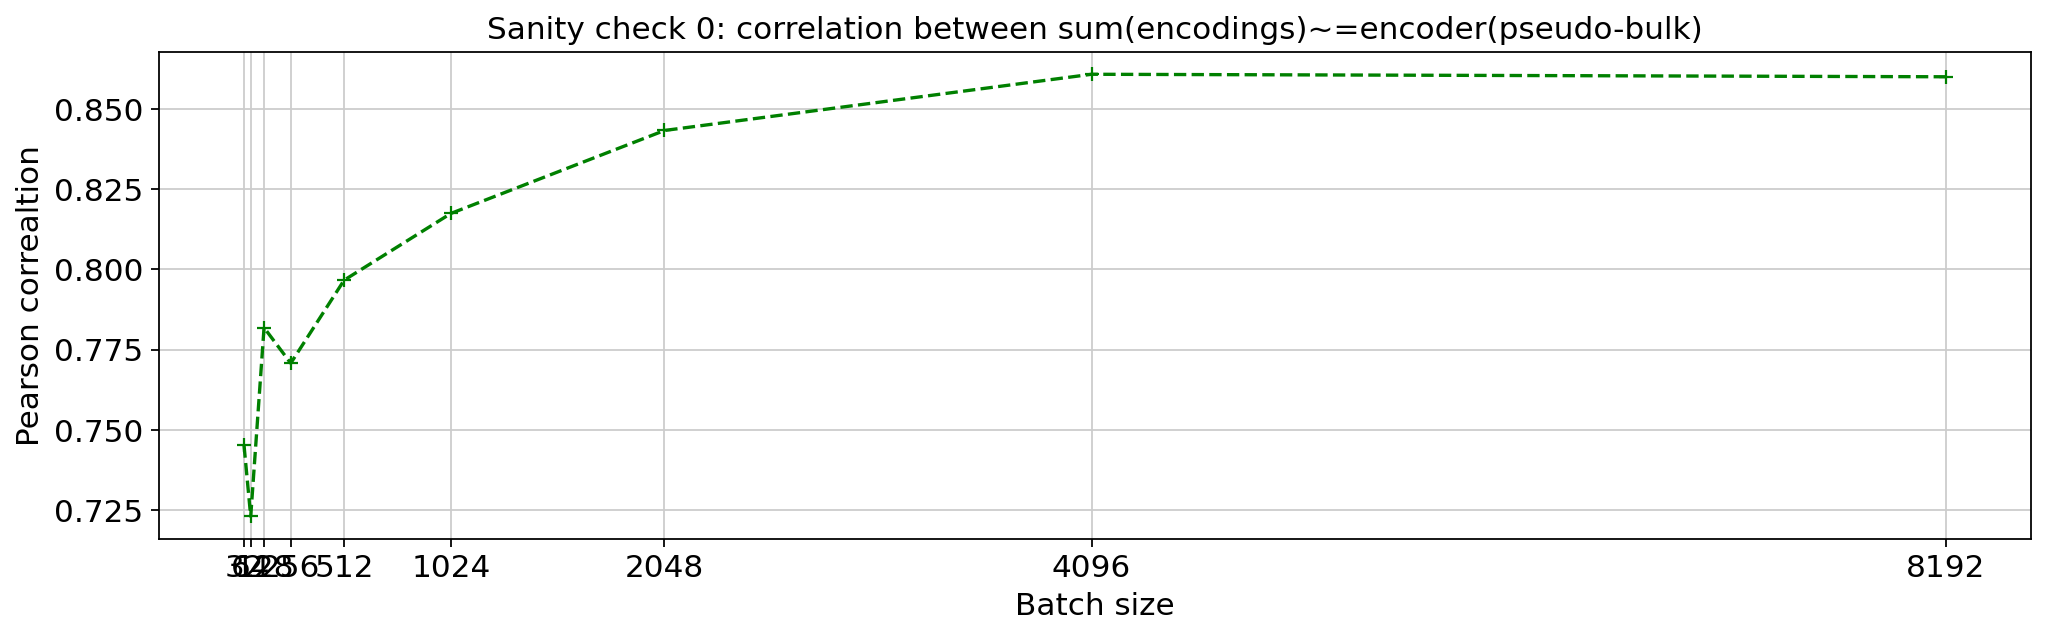

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plt.plot(batch_size, corrs, color="green", linestyle="--", marker="+")
plt.xlabel("Batch size")
plt.ylabel("Pearson correaltion")
plt.xticks(batch_size)
plt.title("Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)")

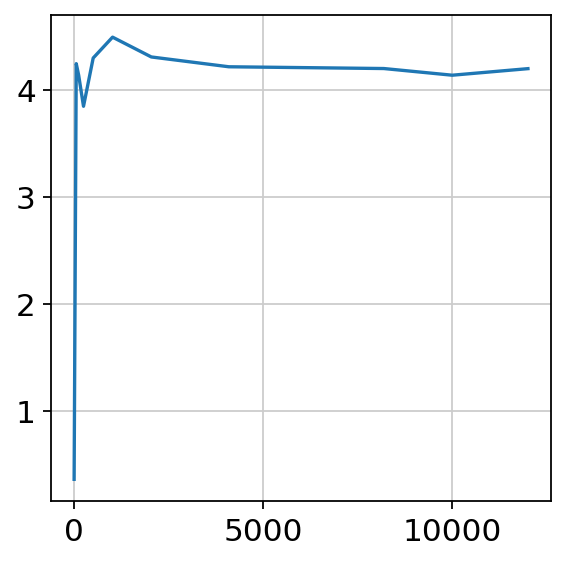

In [262]:
plt.plot(batch_size, -1 * numpy.log(p_values))